In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import cmath
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7)

Populating the interactive namespace from numpy and matplotlib


In [2]:
countByDay = pd.read_csv('data\out_countByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
posByDay = pd.read_csv('data\out_posByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
neutrByDay = pd.read_csv('data\out_neutrByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')
negByDay = pd.read_csv('data\out_negByDay.csv', index_col = 'day', header=0, parse_dates=[0]).sort_values(by = 'day')

In [3]:
ftse = pd.read_csv('data\FTSE.csv', index_col = 'Date', header=0, parse_dates=[0]).sort_values(by = 'Date')
ftse = ftse[['Adj Close', 'Volume']]
ftse.columns = ['price', 'volume']
ftse.head()

,price,volume
Date,,
2015-02-11,6818.200195,623275800
2015-02-12,6828.100098,809863300
2015-02-13,6873.500000,734854200
2015-02-16,6857.100098,415979100
2015-02-17,6898.100098,612932700


In [4]:
# Перевод цены и объема в безразмерные (dimensionless) величины 
ftse['priceDl']  = ftse['price'].apply(lambda x: x / ftse['price'].iloc[0])
ftse['volumeDl'] = ftse['volume'].apply(lambda x: x / ftse['volume'].iloc[0])
ftse.head()

,price,volume,priceDl,volumeDl
Date,,,,
2015-02-11,6818.200195,623275800,1.000000,1.000000
2015-02-12,6828.100098,809863300,1.001452,1.299366
2015-02-13,6873.500000,734854200,1.008111,1.179019
2015-02-16,6857.100098,415979100,1.005705,0.667408
2015-02-17,6898.100098,612932700,1.011719,0.983405


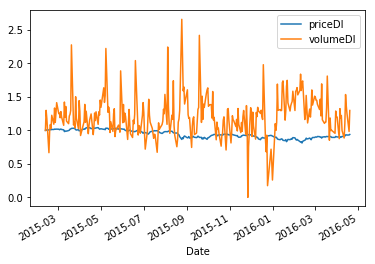

In [5]:
ftse[['priceDl', 'volumeDl']].plot();

In [6]:
results = pd.merge(posByDay, neutrByDay, on='day')
results = pd.merge(results, negByDay, on='day')
results.index.names = ["date"]

results.columns = ['positive', 'neutral', 'negative']
results["sentimentCoef"] = ((results["positive"] - results["negative"])/
                            (results["positive"] + results["neutral"] + results["negative"]))
results.head()

,positive,neutral,negative,sentimentCoef
date,,,,
2016-02-24,738,4624,2511,-0.225200
2016-02-25,1138,6670,3583,-0.214643
2016-02-26,952,5775,3287,-0.233174
2016-02-27,804,4578,2360,-0.200982
2016-02-28,1057,5172,2616,-0.176258


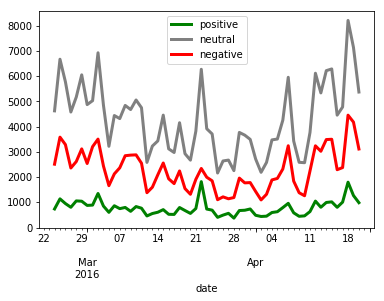

In [7]:
results[['positive', 'neutral', 'negative']].plot(linewidth = 3, 
                                                    color=['g', 'gray', 'r']);

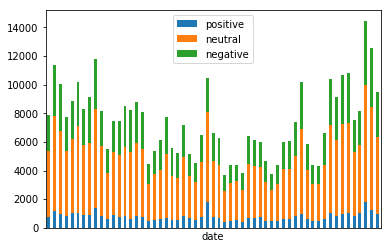

In [8]:
results[['positive','neutral','negative']].plot.bar(stacked=True);
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,      
    top=False,        
    labelbottom=False) 
plt.show()

In [9]:
# allRes = pd.merge(ftse, results[['positive','neutral','negative', 'sentimentCoef']], on = 'date')
allRes = pd.merge(ftse, results, left_index=True, right_index=True)
allRes.head()

,price,volume,priceDl,volumeDl,positive,neutral,negative,sentimentCoef
2016-02-24,5867.200195,834682500,0.860520,1.339186,738,4624,2511,-0.225200
2016-02-25,6012.799805,999956900,0.881875,1.604357,1138,6670,3583,-0.214643
2016-02-26,6096.000000,858937600,0.894078,1.378102,952,5775,3287,-0.233174
2016-02-29,6097.100098,941705500,0.894239,1.510897,1045,6051,3117,-0.202879
2016-03-01,6152.899902,933626200,0.902423,1.497934,878,4872,2539,-0.200386


In [10]:
# Центрирование безразмерных величин цены и объема
allRes['priceDlC'] = allRes['priceDl'] - allRes['priceDl'].mean()
allRes['volumeDlC'] = allRes['volumeDl'] - allRes['volumeDl'].mean()
allRes['sentimentCoefC'] = allRes['sentimentCoef'] - allRes['sentimentCoef'].mean()

allRes['complex'] = allRes['volumeDlC'] + allRes['sentimentCoefC'] * 1j
allRes

,price,volume,priceDl,volumeDl,positive,neutral,negative,sentimentCoef,priceDlC,volumeDlC,sentimentCoefC,complex
2016-02-24,5867.200195,834682500,0.860520,1.339186,738,4624,2511,-0.225200,-0.044794,0.084173,-0.012789,(0.08417323354072792-0.012788972968866635j)
2016-02-25,6012.799805,999956900,0.881875,1.604357,1138,6670,3583,-0.214643,-0.023440,0.349344,-0.002232,(0.34934380489934647-0.0022320614828287844j)
2016-02-26,6096.000000,858937600,0.894078,1.378102,952,5775,3287,-0.233174,-0.011237,0.123089,-0.020762,(0.1230887505558278-0.020762479182484334j)
2016-02-29,6097.100098,941705500,0.894239,1.510897,1045,6051,3117,-0.202879,-0.011076,0.255884,0.009532,(0.2558837347345815+0.009532393807529793j)
2016-03-01,6152.899902,933626200,0.902423,1.497934,878,4872,2539,-0.200386,-0.002892,0.242921,0.012025,(0.2429210944395468+0.01202502403143818j)
2016-03-02,6147.100098,904552300,0.901572,1.451287,891,5028,3206,-0.253699,-0.003742,0.196274,-0.041288,(0.1962741686323839-0.04128755229929887j)
2016-03-03,6130.500000,902840400,0.899138,1.448541,1351,6925,3506,-0.182906,-0.006177,0.193528,0.029505,(0.19352755148472633+0.029504949845835432j)
2016-03-04,6199.399902,866051300,0.909243,1.389515,852,4847,2438,-0.194912,0.003928,0.134502,0.017499,(0.1345021569483109+0.01749894806012814j)
2016-03-07,6182.399902,817955900,0.906750,1.312350,750,4318,2368,-0.217590,0.001435,0.057337,-0.005179,(0.057336638890334024-0.005179024367799406j)
2016-03-08,6125.399902,913517000,0.898390,1.465671,798,4839,2847,-0.241513,-0.006925,0.210657,-0.029102,(0.21065736785173428-0.029102359220304103j)


## Нахождение коэффициента парной корреляции 

In [11]:
def rc(y,x):
#     #Центрирование
#     yr = y.real - y.real.mean()
#     yi = y.imag - y.imag.mean()
#     xr = x.real - x.real.mean()
#     xi = x.imag - x.imag.mean()

    yr = y.real
    yi = y.imag
    xr = x.real
    xi = x.imag
    
    rc_xy = (
        ((yr + 1j*yi)*(xr + 1j*xi)).sum()
        / 
        sqrt(((yr + 1j*yi)**2).sum() * ((xr + 1j*xi)**2).sum())
        )
    return rc_xy;

In [12]:
y = pd.DataFrame({"y":[(1+3j),(2+2j),(3+3j)],
                  "x":[(1+1j),(2+4j),(3+3j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['x'], y['y'])[0][1])

(-0.9701074223859091+0.10586052231081682j)
(0.15811388300841897+0.474341649025257j)


In [13]:
y = pd.DataFrame({"y":[(1+0j),(2+2j)],
                  "x":[(0+1j),(1+2j)]})
print(rc(y['y'], y['x']))
print(np.corrcoef(y['y'], y['x'])[0][1])

(-1.0765386909793453+0.05627008447027136j)
(0.9486832980505138+0.31622776601683794j)


In [14]:
# allRes = allRes.sort_values(by = 'date')
allRes.to_csv("data/out_allRes.csv")
#allRes

In [15]:
print('rc volume-volume:     ' + str(rc(allRes['complex'],
                                    allRes['complex'])))

print('rc volume-price:      ' + str(rc(allRes['complex'],
                                    allRes['priceDl'])))

print('rc price-volume*1000: ' + str(rc(allRes['complex'],
                                    allRes['priceDl']*1000)))

#rc
print(rc(allRes['sentimentCoefC'], allRes['priceDlC']))
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['sentimentCoefC'], allRes['priceDlC'])[0][1])

#rc
print(rc(allRes['priceDlC'],allRes['complex']))
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['priceDlC'],allRes['complex'])[0][1])

rc volume-volume:     (1+0j)
rc volume-price:      (-0.002721963440654711-1.501590088785749e-05j)
rc price-volume*1000: (-0.0027219634406546863-1.5015900887858539e-05j)
(0.018548078910976543+0j)
0.018548078910976533
(-0.16925067162185775-0.0009336831172452041j)
(-0.165151433030158-0.0028913531808145137j)


In [16]:
startShift = -14
endShift = 14

#correlation coef dataframe
rcdf = pd.DataFrame(columns=('shift', 'rc'))

for i in range(startShift, endShift+1):
    if (i < 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'].iloc[:i],
                                  allRes['complex'].shift(i).iloc[:i])],
                            "npcorr":np.corrcoef(allRes['priceDlC'].iloc[:i], 
                                                 allRes['complex'].shift(i).iloc[:i])[0][1]})
    elif (i == 0):
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'],
                                  allRes['complex'])],
                            "npcorr":np.corrcoef(allRes['priceDlC'], 
                                                 allRes['complex'])[0][1]})
    else:    
        row = pd.DataFrame({"shift":[i], 
                            "rc": [rc(allRes['priceDlC'].iloc[i:],
                                  allRes['complex'].shift(i).iloc[i:])],
                            "npcorr":np.corrcoef(allRes['priceDlC'].iloc[i:], 
                                                 allRes['complex'].shift(i).iloc[i:])[0][1]})

    rcdf = rcdf.append(row, ignore_index=True, sort=False)
    
rcdf.head()

,shift,rc,npcorr
0,-14,(0.12706214562704407+0.010878113476022388j),(-0.049522143290745786-0.024486033172962298j)
1,-13,(0.13388961006743544+0.015676474562386338j),(-0.04556132022995264-0.026934397753462413j)
2,-12,(0.11663296121588679+0.02589605604794582j),(-0.07149641946302293-0.038743368764772294j)
3,-11,(-0.1720150171926959+0.01572215549122958j),(-0.3424818432765644-0.03151570408636007j)
4,-10,(0.10400613106185112+0.03444319303024696j),(-0.0354089359311147-0.04009723473682393j)


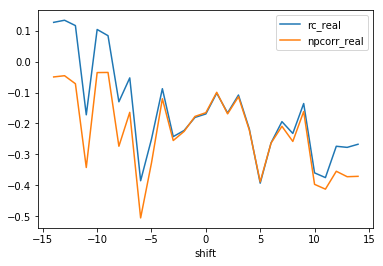

In [17]:
rcdf['rc_real'] = rcdf['rc'].apply(lambda x: x.real)
rcdf['npcorr_real'] = rcdf['npcorr'].apply(lambda x: x.real)
rcdf[['shift','rc_real', 'npcorr_real']].plot(x = 'shift')

In [18]:
def linregb(y, x):
    yr = y.real
    yi = y.imag
    xr = x.real
    xi = x.imag

    b = (
        ((yr + 1j*yi)*(xr + 1j*xi)).sum()
        / 
        ((xr + 1j*xi)**2).sum()
    )

    return b

In [19]:
train = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[0:14]
test  = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[15:18]

In [20]:
#b0 + ib1, где y = 'priceDl', x = 'complex'
b = linregb(train['priceDlC'], train['complex'])
print('b = ', b)

test['lrPriceDlC'] = test['complex'] * b
test['lrPriceDlC_real'] = test['lrPriceDlC'].apply(lambda x: x.real)
test.head(5)

b =  (-0.04439975172248905+0.0015713365018182046j)


,priceDlC,volumeDlC,sentimentCoefC,complex,lrPriceDlC,lrPriceDlC_real
2016-03-16,0.000423,-0.130693,-0.039696,(-0.13069344345844325-0.039695789653795444j),(0.005865131884563547+0.0015571198268021016j),0.005865
2016-03-17,0.004178,0.080856,-0.020738,(0.08085592200705372-0.02073767144625377j),(-0.0035573970022999115+0.0010477993251540672j),-0.003557
2016-03-18,0.002491,0.556696,0.011076,(0.5566964728514794+0.011076261374951046j),(-0.02473458971319319+0.000382974233163755j),-0.024735


In [21]:
lm = LinearRegression()
lm.fit(train[['volumeDlC', 'sentimentCoefC']], train['priceDlC'])
test['sklearnLrPriceDlC'] = lm.predict(test[['volumeDlC', 'sentimentCoefC']])

In [22]:
complexLrRMSE = sqrt(mean_squared_error(test['priceDlC'], test['lrPriceDlC_real']))
sklearnRMSE = sqrt(mean_squared_error(test['priceDlC'], test['sklearnLrPriceDlC']))
print(complexLrRMSE)
print(sklearnRMSE)

0.016640133905213652
0.014881745460659406


0.01136887934206823 0.02177672723146678
0.0075801261550163855 0.01233873790272082
0.005497263939030079 0.008495453457616342
0.005320956944800392 0.009355988729081043
0.00674524482433117 0.009438433163791813
0.006983647142152105 0.00990316979249725
0.006677839812198999 0.008694642386506541
0.006967594287940325 0.008319480390721855
0.006613790479116066 0.00761711155310886
0.0066095417046483276 0.008088249702239774
0.007648416739900867 0.009370431647471941
0.007213194911444453 0.010170121457434305
0.0069074398600848025 0.009589118982228192
0.0067415678012290575 0.009145807470120634
0.0069259534302000825 0.009266944151398065
0.0070369523884757776 0.009279623749867027
0.006873743932832673 0.008974504661289134
0.006536967505056776 0.00851881842293787
0.006368941327239778 0.008258937593401997
0.006374564439986715 0.008245241714702835
0.006686762491832849 0.008458009611544678
0.006400747496994882 0.008288488984272214
0.0063332738573285054 0.008103920335269804
0.006279525615535207 0.00804980823

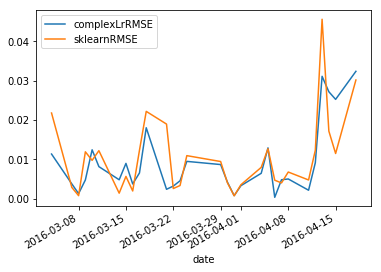

In [23]:
RMSE = pd.DataFrame(columns=('date','complexLrRMSE','sklearnRMSE'))

#for j in range(3, 35):
n = 7
for i in range(0, 37-n):
    train = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i:i+n]
    test  = allRes[['priceDlC','volumeDlC','sentimentCoefC','complex']].iloc[i+n:i+n+1]
    
    b = linregb(train['priceDlC'], train['complex'])
    test['lrPriceDlC'] = test['complex'] * b
    test['lrPriceDlC_real'] = test['lrPriceDlC'].apply(lambda x: x.real)
    
    lm = LinearRegression()
    lm.fit(train[['volumeDlC', 'sentimentCoefC']], train['priceDlC'])
    test['sklearnLrPriceDlC'] = lm.predict(test[['volumeDlC', 'sentimentCoefC']])
    
    row = pd.DataFrame({'complexLrRMSE': [sqrt(mean_squared_error(test['priceDlC'], test['lrPriceDlC_real']))],
                        'sklearnRMSE': [sqrt(mean_squared_error(test['priceDlC'], test['sklearnLrPriceDlC']))],
                        'date': [allRes.index[i+7]]})
    
    RMSE = RMSE.append(row, ignore_index=True, sort=False)  
    
    print(RMSE['complexLrRMSE'].mean(), RMSE['sklearnRMSE'].mean())

RMSE.plot(x='date')

In [24]:
print(RMSE['complexLrRMSE'].mean())
print(RMSE['sklearnRMSE'].mean())

0.009263896225360209
0.010490950990259824


In [25]:
#test[['priceDlC', 'lrPriceDlC_real', 'sklearnLrPriceDlC']].plot(title = 'Shift = 0');

shift = -14   b = (0.006843793590910635+0.0007845092477623537j)
shift = -13   b = (0.0071488490767185366+0.001017210875579875j)
shift = -12   b = (0.006202778059434249+0.0015340588824416601j)
shift = -11   b = (-0.008594528668422068+0.0005509600907123755j)
shift = -10   b = (0.005242982760592808+0.0018866674657738627j)
shift = -9   b = (0.004166458337535747+0.0014846641343227388j)
shift = -8   b = (-0.006499889580939444-0.0010885332250354842j)
shift = -7   b = (-0.0026182889746437384-0.0005979702036347912j)
shift = -6   b = (-0.01910452494223675-0.0011815091999468922j)
shift = -5   b = (-0.012469331336021273+0.0004296404242563163j)
shift = -4   b = (-0.004700432534841325+0.0009340597527313062j)
shift = -3   b = (-0.013724575449715904-0.00028415352233294414j)
shift = -2   b = (-0.013256195902687295+0.0002787288446912062j)
shift = -1   b = (-0.010943900943309826-0.00039079831887941824j)
shift = 0   b = (-0.011080180784120285-0.0003162978775780782j)
shift = 1   b = (-0.005797153555148518+

C:\Users\OAIT\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


shift = 7   b = (-0.011189626270389198-0.0009804401498462881j)
shift = 8   b = (-0.01363919424431729-0.0020714581472163996j)
shift = 9   b = (-0.008009027374576205+0.0007890306415816334j)
shift = 10   b = (-0.021143919050366815+8.432596235351531e-05j)
shift = 11   b = (-0.022095613358498883+0.001968178988267208j)
shift = 12   b = (-0.016351095330011323+0.003508529210607451j)
shift = 13   b = (-0.01655688297747039+0.004015724281821862j)
shift = 14   b = (-0.015995025600732647+0.005260239157817465j)


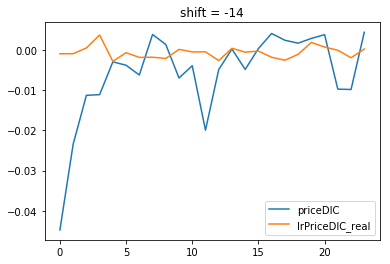

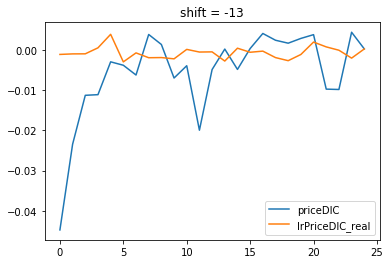

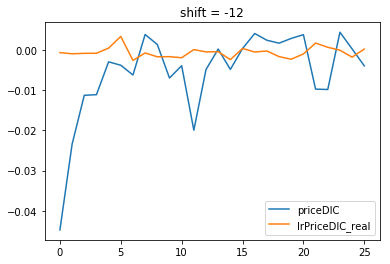

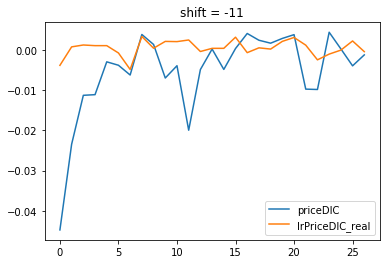

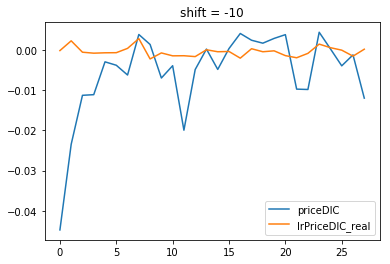

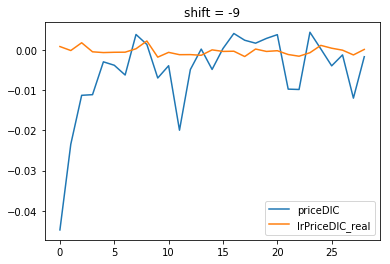

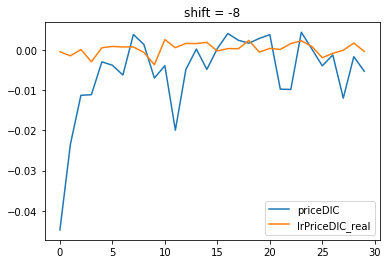

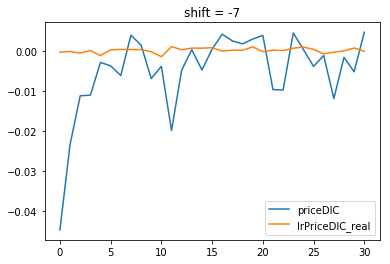

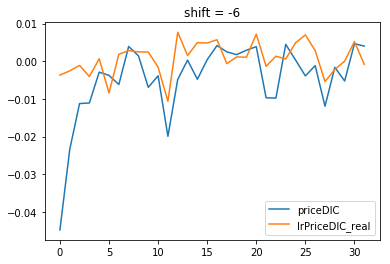

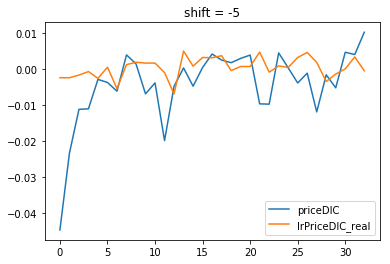

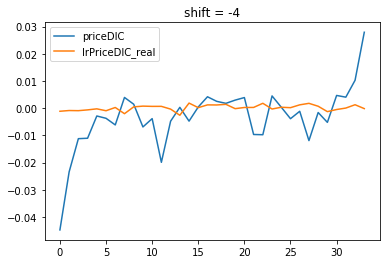

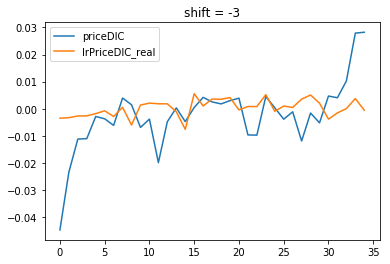

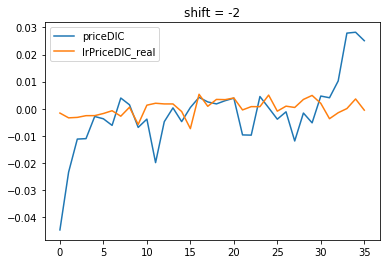

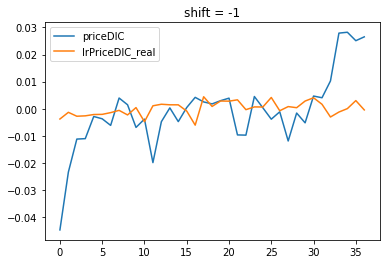

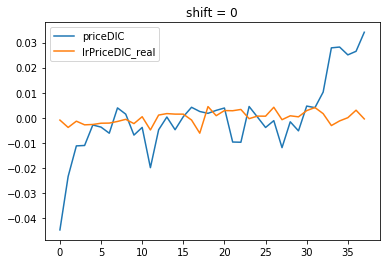

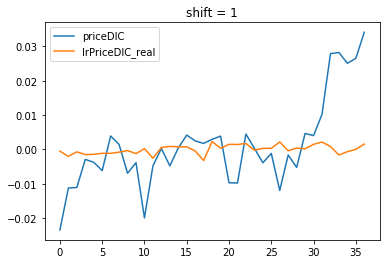

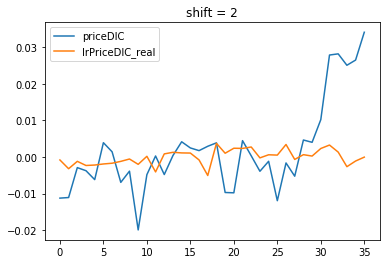

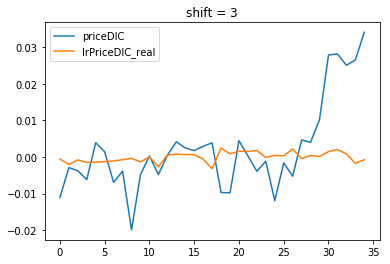

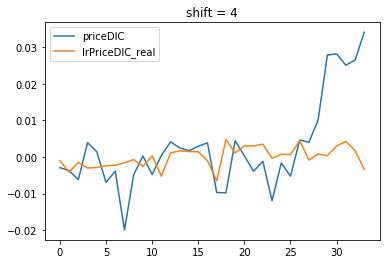

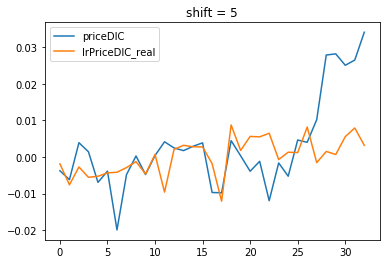

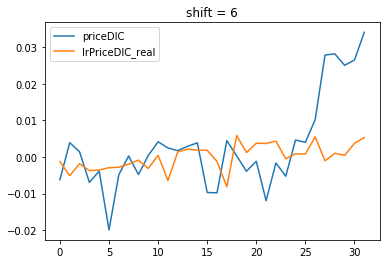

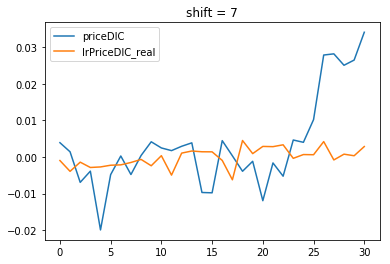

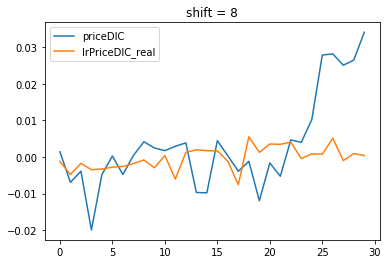

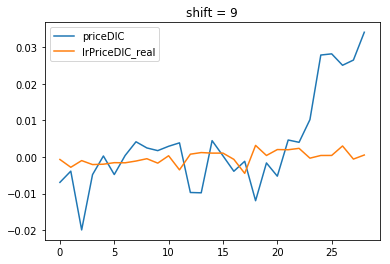

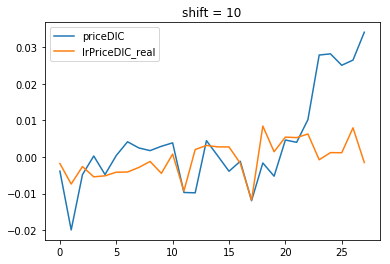

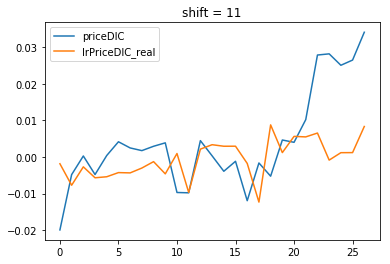

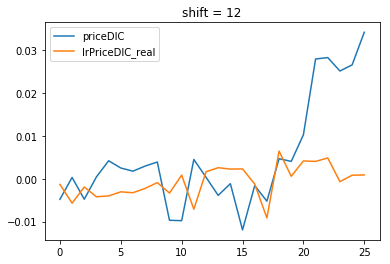

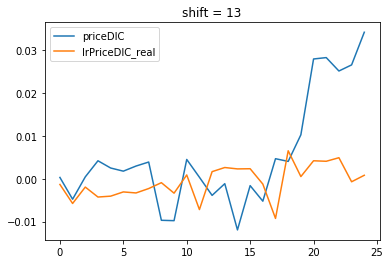

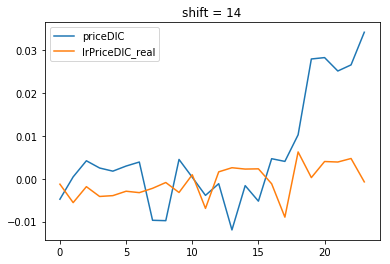

In [26]:
startShift = -14
endShift = 14

for i in range(startShift, endShift+1):
    lrdf = pd.DataFrame(columns=('priceDlC','lrPriceDlС','complex','priceDlC_real','lrPriceDlC_real'))
    if (i < 0):
        b = linregb(allRes['priceDlC'].iloc[:i],
                    allRes['complex'].shift(i).iloc[:i])
        lrdf['priceDlC'] = allRes['priceDlC'].iloc[:i]
        lrdf['complex'] = allRes['complex'].shift(i).iloc[:i]
    
    elif (i == 0):
        b = linregb(allRes['priceDlC'],
                    allRes['complex'])
        lrdf[['priceDlC','complex']] = allRes[['priceDlC','complex']]
    
    else:    
        b = linregb(allRes['priceDlC'].iloc[i:],
                    allRes['complex'].shift(i).iloc[i:])
        lrdf['priceDlC'] = allRes['priceDlC'].iloc[i:]
        lrdf['complex'] = allRes['complex'].shift(i).iloc[i:]
    
    print('shift =', i, '  b =', b)

    lrdf = lrdf.copy(deep = True)
    lrdf['lrPriceDlС'] = lrdf['complex'] * b    

    lrdf = lrdf.append(row, ignore_index=True, sort=False)
    
    lrdf['priceDlC_real'] = lrdf['priceDlC'].apply(lambda x: x.real)
    lrdf['lrPriceDlC_real'] = lrdf['lrPriceDlС'].apply(lambda x: x.real)
    #lrdf['priceDL_imag'] = lrdf['priceDl'].apply(lambda x: x.imag)
    #lrdf['lrPriceDl_imag'] = lrdf['lrPriceDl'].apply(lambda x: x.imag)
    #lrdf[['date', 'priceDl_real', 'lrPriceDl_real', 'priceDL_imag', 'lrPriceDl_imag']].plot(x = 'date')
    lrdf[['priceDlC', 'lrPriceDlC_real']].plot(title = 'shift = ' + str(i))

## Нормирование результатов

In [27]:
allRes["sentimentCoefNorm"] = ((allRes["sentimentCoef"] - allRes["sentimentCoef"].min()) / 
                        (allRes["sentimentCoef"].max() - allRes["sentimentCoef"].min()))
allRes["priceNorm"]  = ((allRes["price"] - allRes["price"].min()) / 
                        (allRes["price"].max() - allRes["price"].min()))
allRes["volumeNorm"] = ((allRes["volume"] - allRes["volume"].min()) / 
                        (allRes["volume"].max() - allRes["volume"].min()))

In [28]:
#Стандартная функция для нахождения корреляции
print(np.corrcoef(allRes['volumeNorm'], allRes['priceNorm'])[0][1])

print('rc volumeNorm-priceNorm: ' + str(rc(allRes['volumeNorm'],
                                            allRes['priceNorm'])))
# allRes[['date', 
#         'sentimentCoefNorm', 
#         'priceNorm', 
#         'volumeNorm']].plot(x='date',
#                             linewidth = 2, 
#                             color = ['r', 'steelblue', 'slateblue'])

-0.1671953407932242
rc volumeNorm-priceNorm: (0.8042252254874648+0j)
